In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import matplotlib.style as style
import scipy.stats as sps
import copy

from solardatatools import DataHandler
from solardatatools.dataio import load_redshift_data
from solardatatools.algorithms import Dilation
from spcqe.quantiles import SmoothPeriodicQuantiles

In [3]:
style.use('seaborn-v0_8-notebook')
dist = sps.norm()

# Load data

In [4]:
query = {
    'siteid': 'TAEHC1041562',
    'api_key': os.environ.get('REDSHIFT_API_KEY'),
    'sensor': 0
    }
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()


            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list: 100%|██████████████████████████████████| 7/7 [00:13<00:00,  1.86s/it]



total time: 13.05 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.17s
Cleaning                   0.11s
Filtering/Summarizing      10.77s
    Data quality           0.08s
    Clear day detect       0.14s
    Clipping detect        2.96s
    Capacity change detect 7.59s



In [5]:
nvals_dil = 101
dil = Dilation(dh)
sig = dil.signal_dil
mat = sig[1:].reshape((nvals_dil, dil.ndays), order='F')
mat[:,~dh.daily_flags.no_errors] = np.nan
sig[1:] = mat.ravel(order='F')

# Transform data

In [6]:
q1 = np.linspace(0, 1, 11)
q1[0] = 0.02
q1[-1] = 0.98

spq = SmoothPeriodicQuantiles(
        num_harmonics=[12, 3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=q1,
        weight=10,
        problem='sequential',
        solver='qss',
        extrapolate='solar',
    )
spq.fit(sig)

100%|███████████████████████████████████████████| 11/11 [09:41<00:00, 52.86s/it]


In [7]:
sig_day = np.delete(sig, np.arange(1, sig.size, nvals_dil))
idx_day = np.delete(np.arange(sig.size), np.arange(1, sig.size, nvals_dil))
transf_day = spq.transform(sig_day, idx_day)
inv_day = spq.inverse_transform(transf_day, idx_day)
fit_quantiles_day  = spq.predict(idx_day)
lower_tail = sig_day < fit_quantiles_day[:, 0]
transf_day_finite = np.copy(transf_day)
transf_day_finite[~np.isfinite(transf_day_finite)] = np.nan

# Test & Plot transformed data

In [8]:
# Check that the transformation + inverse transformation is correct
maxerr_abs = np.nanmax(np.abs(sig_day - inv_day))
maxerr_rel = np.nanmax(np.abs(sig_day - inv_day) / np.nanmean(np.abs(inv_day)))
print(f'Maximum absolute error: {maxerr_abs:.3e}')
print(f'Maximum relative error: {maxerr_rel * 100:.3e}%')

Maximum absolute error: 2.401e-12
Maximum relative error: 1.666e-10%


In [9]:
# Min and max values, should be around +/- 4
print("Signal less than 0 and in lower tail : ", np.sum(sig_day[lower_tail]<=0))
print("Signal less than 0 and not in lower tail: ", np.sum(sig_day[~lower_tail]<=0))
print("Transformed is -inf : ", np.sum(transf_day==-np.inf), "and +inf: ", np.sum(transf_day==+np.inf))
print("Transformed minimum : ", np.round(np.nanmin(transf_day_finite), 3), "and maximum : ", np.round(np.nanmax(transf_day_finite), 3))

Signal less than 0 and in lower tail :  148
Signal less than 0 and not in lower tail:  647
Transformed is -inf :  148 and +inf:  0
Transformed minimum :  -8.662 and maximum :  4.235


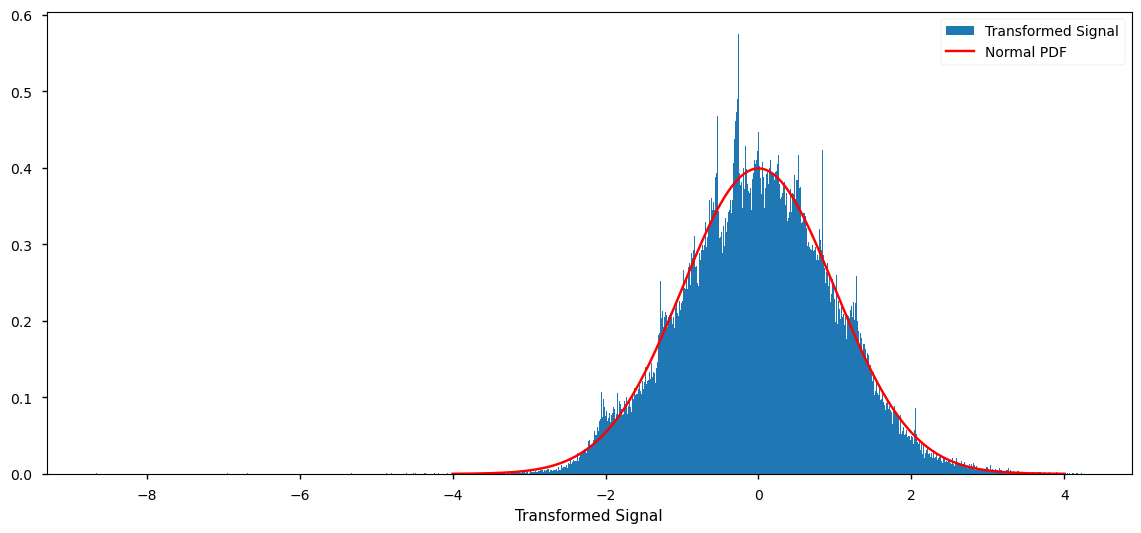

In [10]:
# Plot pdf
spq.plot_pdf(transf_day_finite);

In [11]:
# Number of outliers
qo = 0.0001
x = dist.ppf(qo)
nexp = np.round(len(sig) * qo, 3)
print("Normal distribution: expect", nexp, "positive and", nexp, "negative outliers.")
print("Asymptote extrapolation:", np.sum(transf_day_finite>-x), "positive and", np.sum(transf_day_finite<x), "negative outliers.")

Normal distribution: expect 12.958 positive and 12.958 negative outliers.
Asymptote extrapolation: 36 positive and 27 negative outliers.


In [12]:
# Perform a Kolmogorov-Smirnov test to compare the transformed signal to a standard normal distribution
res = sps.kstest(transf_day_finite, 'norm', nan_policy='omit')
print(f'KS statistic: {res.statistic:.3f}, p-value: {res.pvalue:.3e}, statistic location: {res.statistic_location:.3f}')

KS statistic: 0.006, p-value: 8.689e-05, statistic location: -0.334


The KS statistic quantifies the distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution (standard normal in this case). A smaller KS statistic indicates that the sample distribution is closer to the reference distribution.

The p-value indicates the probability of observing the data if the null hypothesis is true (i.e., the sample comes from the reference distribution). A low p-value (typically < 0.05) suggests that the sample does not come from the reference distribution.

signal :  2.931632440673121


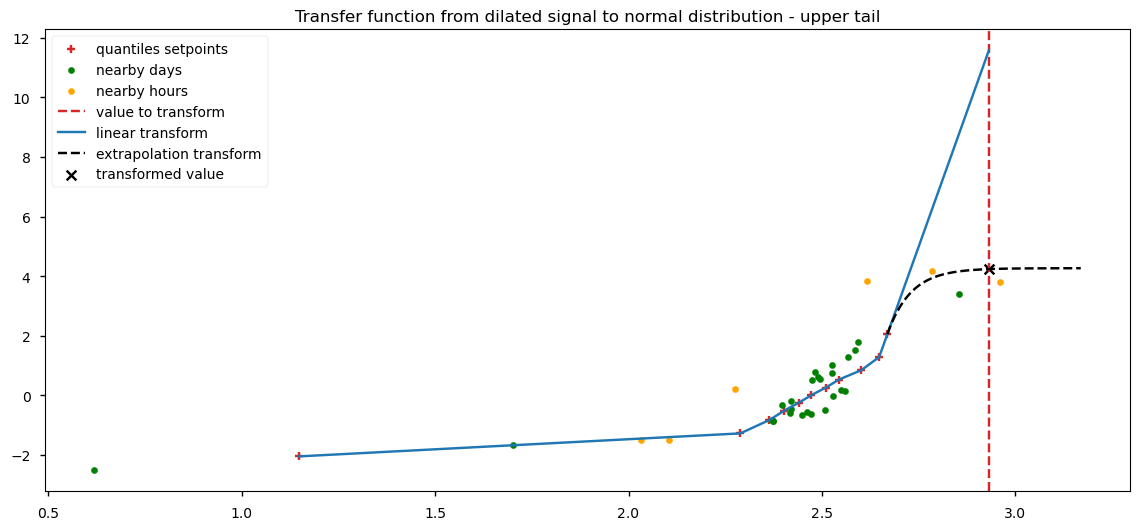

In [19]:
# Plot transformation - upper tail
idx = np.nanargmax(transf_day_finite)
print("signal : ", sig_day[idx])
spq.plot_tail_transformation_solar(sig_day, transf_day_finite, 'upper', idx, 0.5, h_per_day=nvals_dil-1);

signal :  9.33449884976161e-05


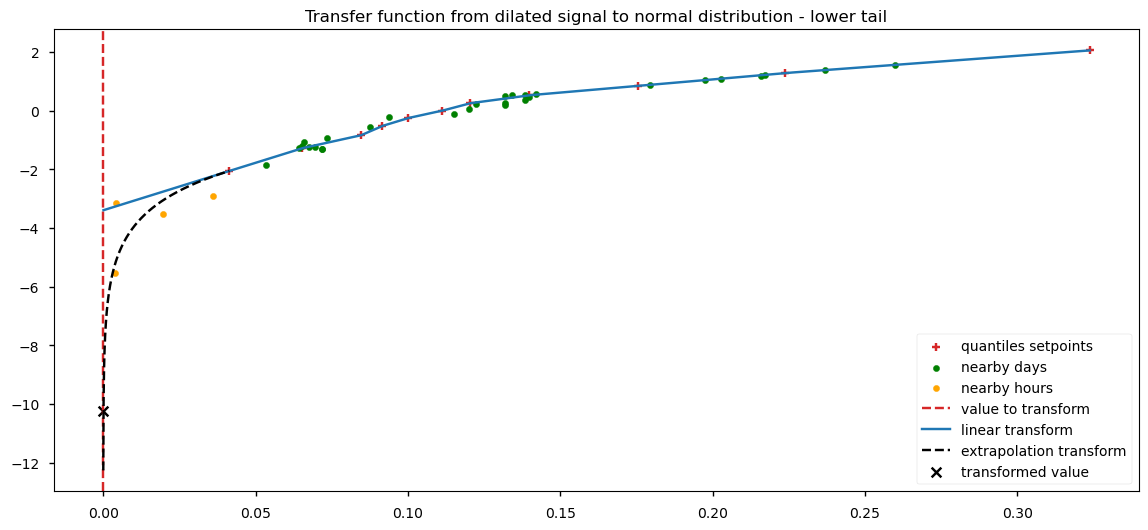

In [ ]:
# Plot transformation - lower tail
idx = np.nanargmin(transf_day_finite)
print("signal : ", sig_day[idx])
spq.plot_tail_transformation_solar(sig_day, transf_day, 'lower', idx, 0.05, h_per_day=dil.nvals_dil - 1);

# Linear option

In [ ]:
extrapolate = {'lower': 'linear', 'upper': 'linear'}
spq_lin = copy.copy(spq)
spq_lin.extrapolate = extrapolate

In [ ]:
transf_lin_day = spq_lin.transform(sig_day, idx_day)
inv_lin_day = spq_lin.inverse_transform(transf_lin_day, idx_day)
transf_lin_day_finite = np.copy(transf_lin_day)
transf_lin_day_finite[~np.isfinite(transf_lin_day_finite)] = np.nan

In [ ]:
# Min and max values, should be around +/- 4
print("Transformed is -inf : ", np.sum(transf_lin_day==-np.inf), "and +inf: ", np.sum(transf_lin_day==+np.inf))
print("Transformed minimum : ", np.round(np.nanmin(transf_lin_day_finite), 3), "and maximum : ", np.round(np.nanmax(transf_lin_day_finite), 3))

Transformed is -inf :  0 and +inf:  0
Transformed minimum :  -3.671 and maximum :  13.947


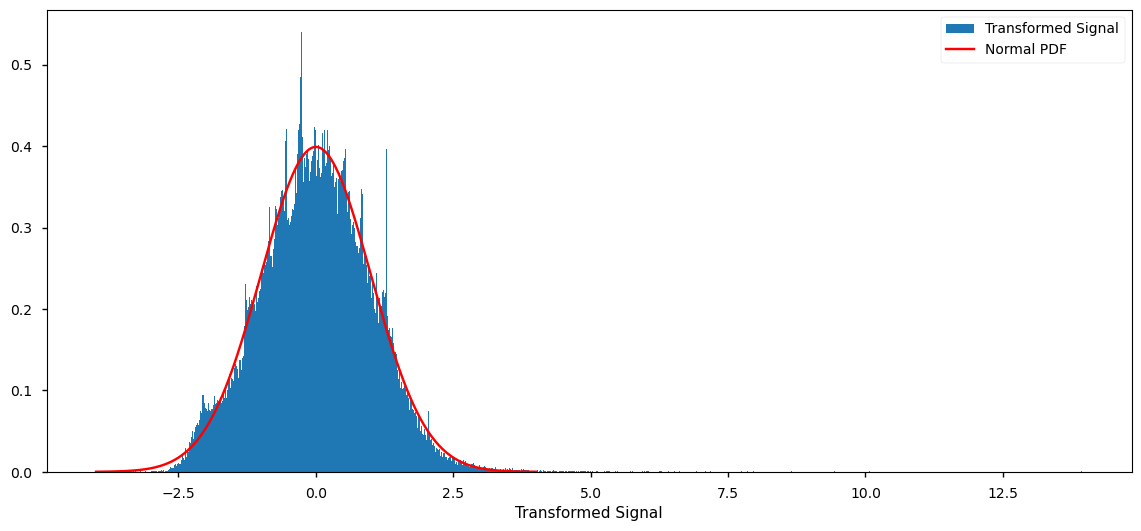

In [ ]:
# Plot pdf
spq.plot_pdf(transf_lin_day_finite);

In [ ]:
# Number of outliers
qo = 0.0001
x = dist.ppf(qo)
nexp = np.round(len(sig) * qo, 3)
print("Normal distribution: expect", nexp, "positive and", nexp, "negative outliers.")
print("Asymptote extrapolation:", np.sum(transf_lin_day_finite>-x), "positive and", np.sum(transf_lin_day_finite<x), "negative outliers.")

Normal distribution: expect 12.958 positive and 12.958 negative outliers.
Asymptote extrapolation: 174 positive and 0 negative outliers.


In [ ]:
# Perform a Kolmogorov-Smirnov test to compare the transformed signal to a standard normal distribution
res = sps.kstest(transf_lin_day_finite, 'norm', nan_policy='omit')
print(f'KS statistic: {res.statistic:.3f}, p-value: {res.pvalue:.3e}, statistic location: {res.statistic_location:.3f}')

KS statistic: 0.006, p-value: 1.101e-03, statistic location: -2.326


signal :  2.9837531839868863


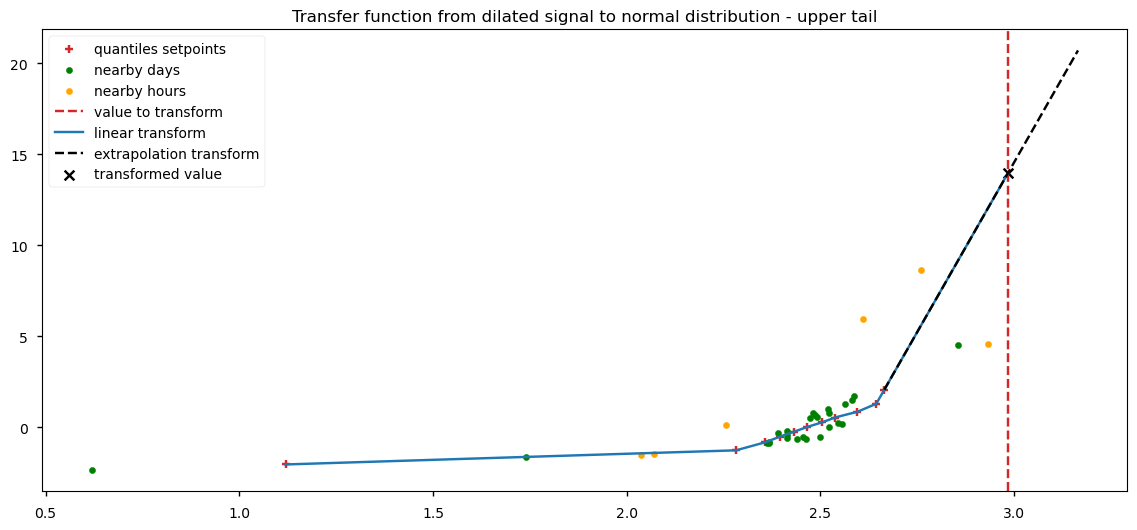

In [ ]:
# Plot transformation - upper tail
idx = np.nanargmax(transf_lin_day_finite)
print("signal : ", sig_day[idx])
spq_lin.plot_tail_transformation_solar(sig_day, transf_lin_day_finite, 'upper', idx, 0.5, h_per_day=nvals_dil-1);

signal :  0.04305711180323175


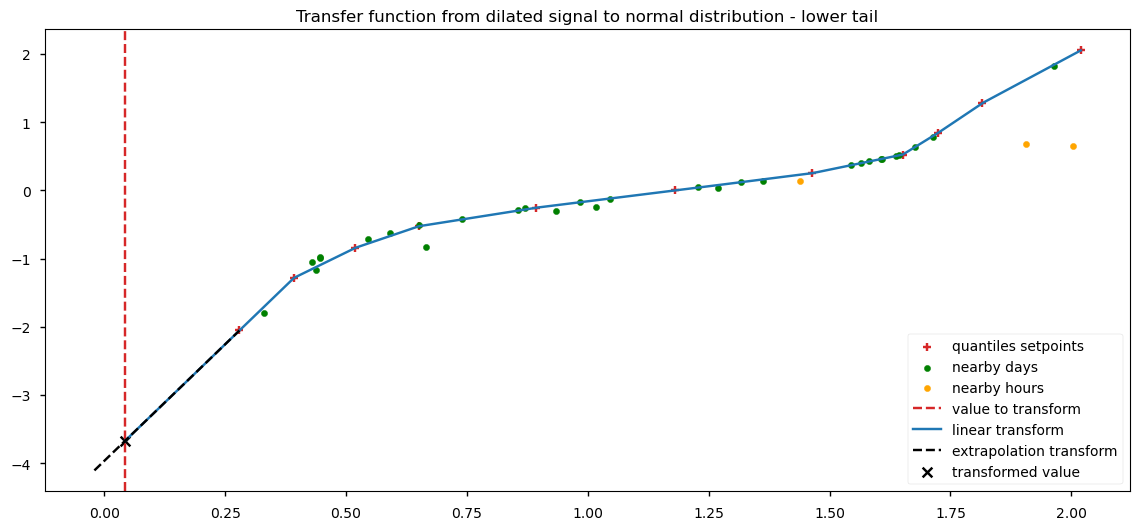

In [ ]:
# Plot transformation - lower tail
idx = np.nanargmin(transf_lin_day_finite)
print("signal : ", sig_day[idx])
spq_lin.plot_tail_transformation_solar(sig_day, transf_lin_day_finite, 'lower', idx, 0.3, h_per_day=dil.nvals_dil - 1);

# Both asymptotes in output space

In [ ]:
extrapolate = {'lower':(-dist.ppf(0.99999), 'output'), 'upper':(dist.ppf(0.99999), 'output')}
spq_out = copy.copy(spq)
spq_out.extrapolate = extrapolate

In [ ]:
transf_out_day = spq_out.transform(sig_day, idx_day)
inv_out_day = spq_out.inverse_transform(transf_out_day, idx_day)
transf_out_day_finite = np.copy(transf_out_day)
transf_out_day_finite[~np.isfinite(transf_out_day_finite)] = np.nan

In [ ]:
# Min and max values, should be around +/- 4
print("Transformed is -inf : ", np.sum(transf_out_day==-np.inf), "and +inf: ", np.sum(transf_out_day==+np.inf))
print("Transformed minimum : ", np.round(np.nanmin(transf_out_day_finite), 3), "and maximum : ", np.round(np.nanmax(transf_out_day_finite), 3))

Transformed is -inf :  0 and +inf:  0
Transformed minimum :  -3.201 and maximum :  4.255


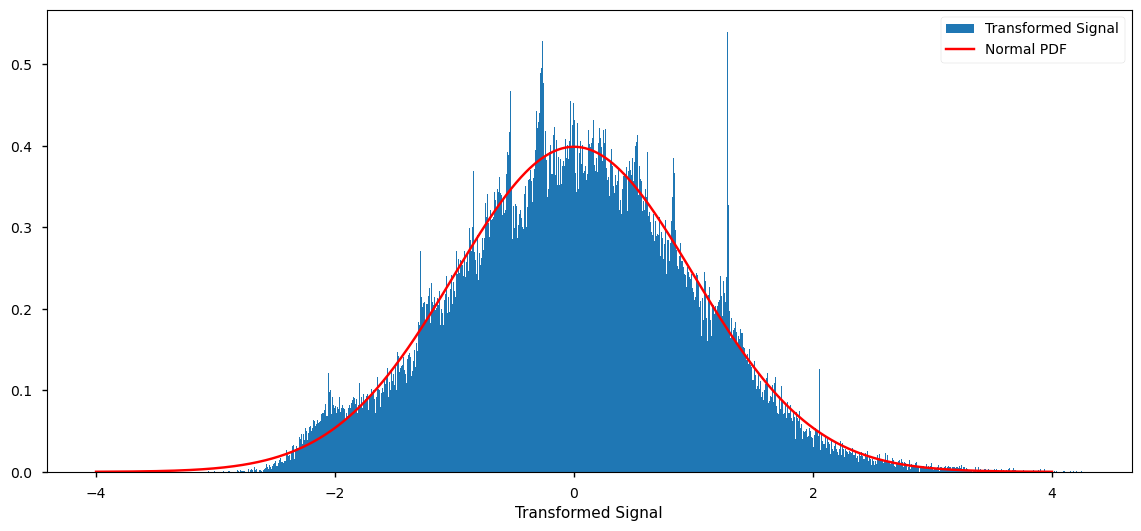

In [ ]:
# Plot pdf
spq.plot_pdf(transf_out_day_finite);

In [ ]:
# Number of outliers
qo = 0.0001
x = dist.ppf(qo)
nexp = np.round(len(sig) * qo, 3)
print("Normal distribution: expect", nexp, "positive and", nexp, "negative outliers.")
print("Asymptote extrapolation:", np.sum(transf_out_day_finite>-x), "positive and", np.sum(transf_out_day_finite<x), "negative outliers.")

Normal distribution: expect 12.958 positive and 12.958 negative outliers.
Asymptote extrapolation: 33 positive and 0 negative outliers.


In [ ]:
# Perform a Kolmogorov-Smirnov test to compare the transformed signal to a standard normal distribution
res = sps.kstest(transf_out_day_finite, 'norm', nan_policy='omit')
print(f'KS statistic: {res.statistic:.3f}, p-value: {res.pvalue:.3e}, statistic location: {res.statistic_location:.3f}')

KS statistic: 0.006, p-value: 2.521e-04, statistic location: -2.360


signal :  2.9837531839868863


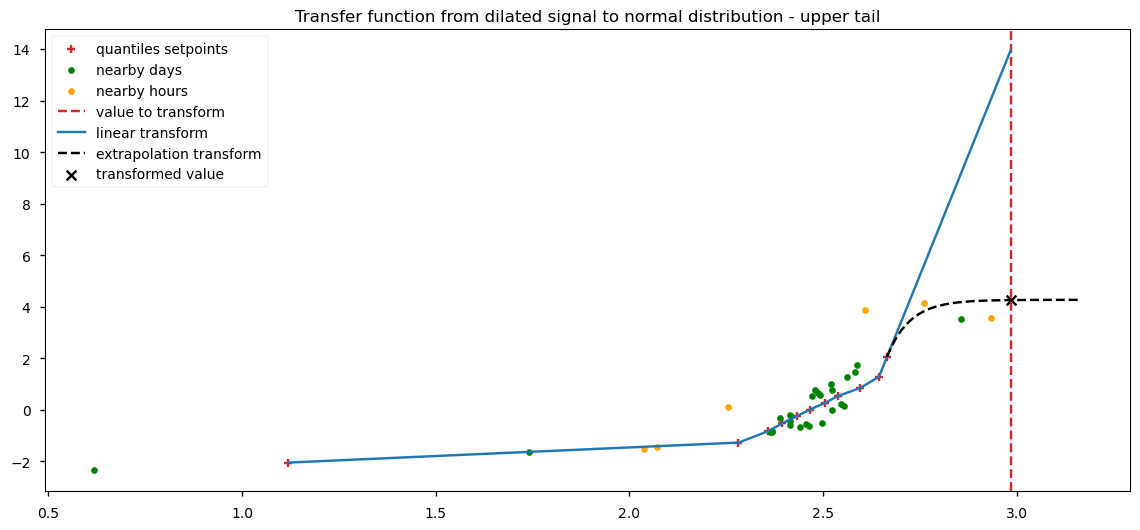

In [ ]:
# Plot transformation - upper tail
idx = np.nanargmax(transf_out_day_finite)
print("signal : ", sig_day[idx])
spq_out.plot_tail_transformation_solar(sig_day, transf_out_day_finite, 'upper', idx, 0.5, h_per_day=nvals_dil-1);

signal :  0.04305711180323175


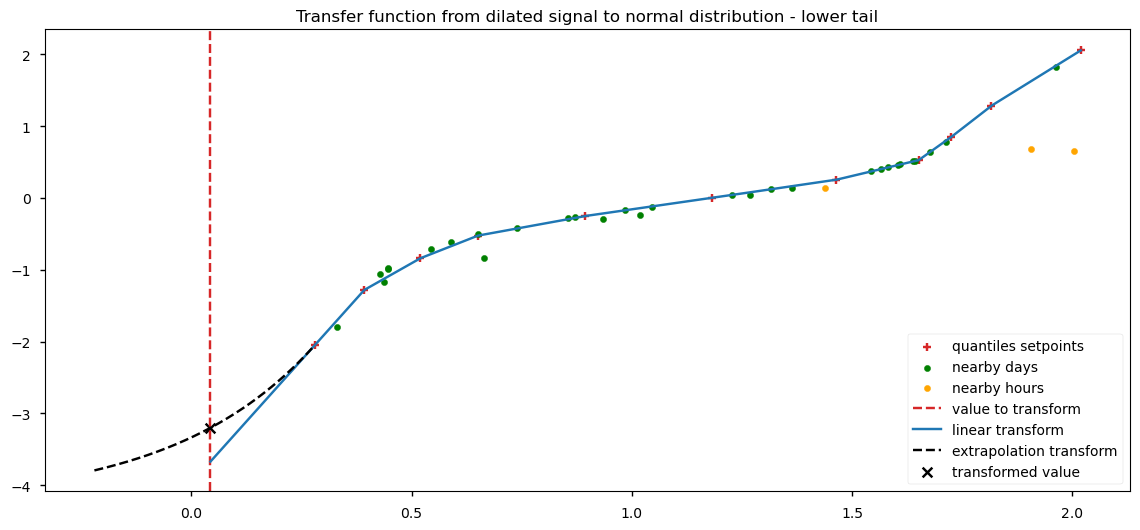

In [ ]:
# Plot transformation - lower tail
idx = np.nanargmin(transf_out_day_finite)
print("signal : ", sig_day[idx])
spq_out.plot_tail_transformation_solar(sig_day, transf_out_day_finite, 'lower', idx, 0.5, h_per_day=dil.nvals_dil - 1);